In [2]:
from data_extraction import load_data, build_offer_supply_curves, fetch_weather_data
from embedding import find_intersection
from model import process_embedding_data, get_train_test_split, compute_baseline_mae

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# CONFIG
root_path = r"C:\Users\azize\Documents\PHD\repos\phd-uc3m"

# Load and process AEMO Data

In [ ]:
# NOTE: Only need to run once
# Process raw AEMO data into parquet table

# Data paths 
input_path_format = root_path + r"\aemo\data\stem-bids-and-offers-{year}-{month}.csv"
parquet_output_path = root_path + r"\aemo\data\aemo_bids_offers.parquet"

# Years and months to iterate over
years = [2024]
months = [f"{month:02}" for month in range(1, 4 + 1)]

# Load data
data = load_data(input_path_format, parquet_output_path, years, months)

In [3]:
# Read data
parquet_output_path = root_path + r"\aemo\data\aemo_bids_offers.parquet"
data = pd.read_parquet(parquet_output_path)

In [6]:
# Build offer and supply curves, train test split
test_date = "2024-01-01"
data_curves_train = build_offer_supply_curves(data[data["Trading Date"] < test_date])
data_curves_test = build_offer_supply_curves(data[data["Trading Date"] >= test_date])

# Curve embedding

In [11]:
# CONFIG
selected_days = sorted(list(data_curves_train.keys()))

# Extract curves
supply_curves_raw = []
demand_curves_raw = []
for day in selected_days:
    day_supply_curves = [interval["supply_curve"] for interval in data_curves_train[day].values()]
    supply_curves_raw = supply_curves_raw + day_supply_curves
    day_demand_curves = [interval["demand_curve"] for interval in data_curves_train[day].values()]
    demand_curves_raw = demand_curves_raw + day_demand_curves

# Process supply curves
supply_curves = pad_sequences(supply_curves_raw, padding='pre', dtype='float32')
n_in_supply = supply_curves.shape[1]

# Process demand curves
demand_curves = pad_sequences(demand_curves_raw, padding='pre', dtype='float32')
n_in_demand = demand_curves.shape[1]

# Get intersection points
cross_points = []
for i in range(len(demand_curves_raw)):
    x_point = find_intersection(supply_curves_raw[i], demand_curves_raw[i])
    cross_points.append(x_point)
cross_points = np.array(cross_points)

# Scale data
scaler_supply = MinMaxScaler()
scaler_demand = MinMaxScaler()
scaler_cross = MinMaxScaler()
supply_curves_scaled = scaler_supply.fit_transform(supply_curves.reshape(-1, 2)).reshape(supply_curves.shape)
demand_curves_scaled = scaler_demand.fit_transform(demand_curves.reshape(-1, 2)).reshape(demand_curves.shape)
cross_points_scaled = scaler_cross.fit_transform(cross_points)

In [184]:
cross_points.shape

(17520, 2)

In [20]:
# Building embedding NN
latent_dim = 32
lstm_neurons = 64

input_curve_supply = Input(shape=(n_in_supply, 2))
layer_supply = LSTM(lstm_neurons, activation='tanh', return_sequences=False)(input_curve_supply)
latent_space_supply = Dense(latent_dim, activation='tanh', name='latent_space_supply')(layer_supply)
encoder_supply = Model(inputs=input_curve_supply, outputs=latent_space_supply, name='encoder')

input_curve_demand = Input(shape=(n_in_demand, 2))
layer_demand = LSTM(lstm_neurons, activation='tanh', return_sequences=False)(input_curve_demand)
latent_space_demand = Dense(latent_dim, activation='tanh', name='latent_space_demand')(layer_demand)
encoder_demand = Model(inputs=input_curve_demand, outputs=latent_space_demand, name='encoder')

both_curves = Concatenate()([latent_space_supply, latent_space_demand])
both_curves = Dense(16, activation='relu')(both_curves)
price_quantity = Dense(2)(both_curves)

def mae_price(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true[:, 0], y_pred[:, 0])

def mae_quantity(y_true, y_pred):
    return tf.keras.metrics.mean_absolute_error(y_true[:, 1], y_pred[:, 1])

price_quantity_model = Model(inputs=[input_curve_supply, input_curve_demand], outputs=price_quantity)
price_quantity_model.compile(optimizer='adam', loss='mae', metrics=[mae_price, mae_quantity])

In [21]:
# Fit embedding
history = price_quantity_model.fit(
    [supply_curves_scaled, demand_curves_scaled], 
    cross_points_scaled,
    epochs=100, 
    batch_size=64, 
    validation_split=0.1,
)

Epoch 1/100


247/247 [==============================] - 16s 55ms/step - loss: 0.0413 - mae_price: 0.0213 - mae_quantity: 0.0613 - val_loss: 0.0256 - val_mae_price: 0.0023 - val_mae_quantity: 0.0483
Epoch 2/100
247/247 [==============================] - 22s 89ms/step - loss: 0.0359 - mae_price: 0.0194 - mae_quantity: 0.0524 - val_loss: 0.0239 - val_mae_price: 0.0014 - val_mae_quantity: 0.0457
Epoch 3/100
247/247 [==============================] - 33s 135ms/step - loss: 0.0341 - mae_price: 0.0185 - mae_quantity: 0.0496 - val_loss: 0.0241 - val_mae_price: 0.0027 - val_mae_quantity: 0.0452
Epoch 4/100
247/247 [==============================] - 34s 136ms/step - loss: 0.0352 - mae_price: 0.0191 - mae_quantity: 0.0513 - val_loss: 0.0268 - val_mae_price: 0.0052 - val_mae_quantity: 0.0480
Epoch 5/100
247/247 [==============================] - 33s 134ms/step - loss: 0.0330 - mae_price: 0.0182 - mae_quantity: 0.0477 - val_loss: 0.0236 - val_mae_price: 0.0021 - val_mae_quantity: 0.0443
Epoch 6/10

   MAE Price: 0.0011 (Mean: 0.0422 --- 2.61%)
MAE Quantity: 0.031 (Mean: 0.4234 --- 7.32%)


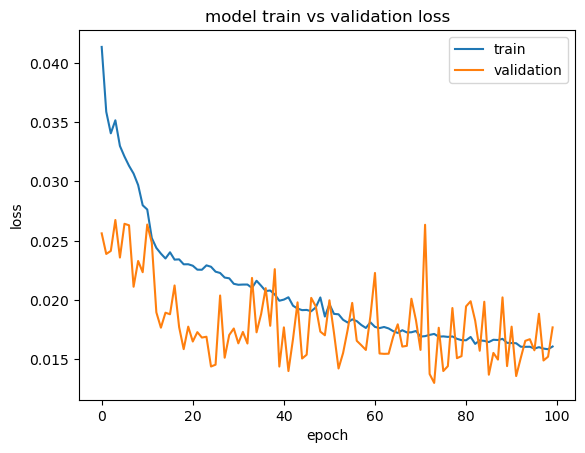

In [22]:
# Show MAE
mae_price = round(np.mean(history.history['val_mae_price'][-10:]), 4)
mean_price = round(cross_points_scaled.mean(axis=0)[0], 4)
mae_quantity = round(np.mean(history.history['val_mae_quantity'][-10:]), 4)
mean_quantity = round(cross_points_scaled.mean(axis=0)[1], 4)
mae_p_price = round((mae_price / mean_price) * 100, 2)
mae_p_quantity = round((mae_quantity / mean_quantity) * 100, 2)
print(f"   MAE Price: {mae_price} (Mean: {mean_price} --- {mae_p_price}%)")
print(f"MAE Quantity: {mae_quantity} (Mean: {mean_quantity} --- {mae_p_quantity}%)")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Model development

## Load supply and demand data

In [23]:
# Load test data
selected_days_test = sorted(list(data_curves_test.keys()))

# Extract curves
supply_curves_raw = []
demand_curves_raw = []
for day in selected_days_test:
    day_supply_curves = [interval["supply_curve"] for interval in data_curves_test[day].values()]
    supply_curves_raw = supply_curves_raw + day_supply_curves
    day_demand_curves = [interval["demand_curve"] for interval in data_curves_test[day].values()]
    demand_curves_raw = demand_curves_raw + day_demand_curves

# Process supply curves
supply_curves = pad_sequences(supply_curves_raw, padding='pre', dtype='float32', maxlen=n_in_supply)

# Process demand curves
demand_curves = pad_sequences(demand_curves_raw, padding='pre', dtype='float32', maxlen=n_in_demand)

# Get intersection points
cross_points_test = []
for i in range(len(demand_curves_raw)):
    x_point = find_intersection(supply_curves_raw[i], demand_curves_raw[i])
    cross_points_test.append(x_point)
cross_points_test = np.array(cross_points_test)

# Scale data
scaler_supply = MinMaxScaler()
scaler_demand = MinMaxScaler()
scaler_cross = MinMaxScaler()
supply_curves_scaled_test = scaler_supply.fit_transform(supply_curves.reshape(-1, 2)).reshape(supply_curves.shape)
demand_curves_scaled_test = scaler_demand.fit_transform(demand_curves.reshape(-1, 2)).reshape(demand_curves.shape)

In [24]:
# Generate embeddings
supply_curves_train_emb = encoder_supply.predict(supply_curves_scaled)
supply_curves_test_emb = encoder_supply.predict(supply_curves_scaled_test)
demand_curves_train_emb = encoder_demand.predict(demand_curves_scaled)
demand_curves_test_emb = encoder_demand.predict(demand_curves_scaled_test)

182/182 [==============================] - 1s 8ms/step


In [ ]:
embeddings_columns = [f"X0_{i + 1}" for i in range(latent_dim)]

In [ ]:
# Process supply curves data
# Create train dataframe
train_days = np.repeat(selected_days, 48)
train_intervals = np.tile(np.arange(1, 49), len(selected_days))
supply_train_data = np.hstack((
    supply_curves_train_emb,
    train_days.reshape(-1, 1), 
    train_intervals.reshape(-1, 1),
))

# Create test dataframe
test_days = np.repeat(selected_days_test, 48)
test_intervals = np.tile(np.arange(1, 49), len(selected_days_test))
supply_test_data = np.hstack((
    supply_curves_test_emb,
    test_days.reshape(-1, 1),
    test_intervals.reshape(-1, 1),
))

# Process test and train dataframes
supply_data_columns = embeddings_columns + ["date", "interval"]
supply_train_data = pd.DataFrame(supply_train_data, columns=(supply_data_columns))
supply_test_data = pd.DataFrame(supply_test_data, columns=(supply_data_columns))
supply_data = pd.concat([supply_train_data, supply_test_data], ignore_index=True)

# Process data
supply_data = process_embedding_data(supply_data, embeddings_columns, latent_dim)

In [181]:
# Process demmand curves data
# Create train dataframe
train_days = np.repeat(selected_days, 48)
train_intervals = np.tile(np.arange(1, 49), len(selected_days))
demand_train_data = np.hstack((
    demand_curves_train_emb,
    train_days.reshape(-1, 1), 
    train_intervals.reshape(-1, 1),
))

# Create test dataframe
test_days = np.repeat(selected_days_test, 48)
test_intervals = np.tile(np.arange(1, 49), len(selected_days_test))
demand_test_data = np.hstack((
    demand_curves_test_emb,
    test_days.reshape(-1, 1),
    test_intervals.reshape(-1, 1),
))

# Process test and train dataframes
demand_data_columns = embeddings_columns + ["date", "interval"]
demand_train_data = pd.DataFrame(demand_train_data, columns=(demand_data_columns))
demand_test_data = pd.DataFrame(demand_test_data, columns=(demand_data_columns))
demand_data = pd.concat([demand_train_data, demand_test_data], ignore_index=True)

# Process data
demand_data = process_embedding_data(demand_data, embeddings_columns)

In [182]:
# Save processed data
supply_data.to_csv(root_path + r"\aemo\data\processed\supply_data.csv", index=False)
demand_data.to_csv(root_path + r"\aemo\data\processed\demand_data.csv", index=False)

## NN with time features only

In [124]:
supply_data = pd.read_csv(root_path + r"\aemo\data\processed\supply_data.csv")

# Target columns split
feature_cols = [c for c in supply_data.columns if (c not in embeddings_columns) and (c != "date")]
X_train, y_train, X_test, y_test = get_train_test_split(supply_data.dropna(), test_date, feature_cols, embeddings_columns)

# Model definition using Sequential
input_dim = X_train.shape[1]

model_supply = Sequential(name='model_supply')
model_supply.add(Dense(64, activation='relu', input_shape=(input_dim,), name='dense_supply_1'))
model_supply.add(Dense(48, activation='relu', name='dense_supply_2'))
model_supply.add(Dense(32, activation='tanh', name='output_supply'))

# Compile the model
model_supply.compile(optimizer='adam', loss='mae')

# Train model
history = model_supply.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0579 - val_loss: 0.0296
Epoch 2/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0248 - val_loss: 0.0279
Epoch 3/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0232 - val_loss: 0.0235
Epoch 4/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0231
Epoch 5/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0233
Epoch 6/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0215 - val_loss: 0.0221
Epoch 7/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0212 - val_loss: 0.0230
Epoch 8/40
422/422 [==============================] - 1s 1ms/step - loss: 0.0207 - val_loss: 0.0276
Epoch 9/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0209 - val_loss: 0.0209
Epoch 10/40
422/422 [==============================] - 1s 2ms/step - loss: 0.0204 - val_loss: 0.0208

MAE Test: 0.0325 (Baseline: 0.0193 --- 68.39%)


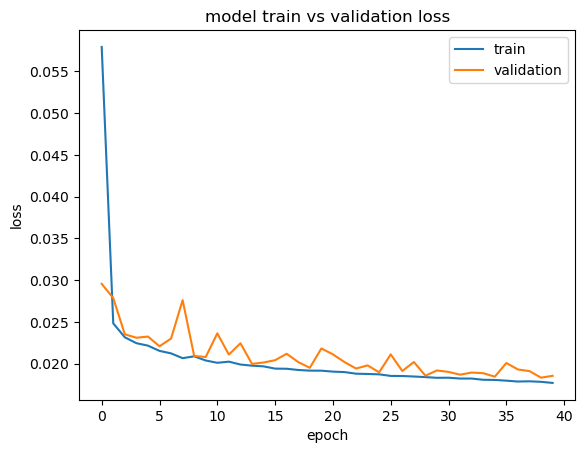

In [125]:
mae_emb_test = round(np.mean(model_supply.evaluate(X_test, y_test, verbose=-1)), 4)
baseline_mae = round(compute_baseline_mae(y_test, shift_days=1), 4)
baseline_p_mae = round(((mae_emb_test - baseline_mae) / baseline_mae) * 100, 2)
print(f"MAE Test: {mae_emb_test} (Baseline: {str(baseline_mae)} --- {baseline_p_mae}%)")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Other features

In [ ]:
au_coordinates = {
    "AU-NSW": (-33.869, 151.209),  # Sydney
    "AU-QLD": (-27.471, 153.026),  # Brisbane
    "AU-TAS": (-42.887, 147.326),  # Hobart
    "AU-VIC": (-37.814, 144.963),  # Melbourne
    "AU-WA": (-31.951, 115.867),  # Perth
    "AU-SA": (-34.929, 138.601),  # Adelaide
}
supply_data = pd.read_csv(root_path + r"\aemo\data\processed\supply_data.csv")

In [ ]:
for lat, lon in 

In [ ]:
weather_data = fetch_weather_data(*au_coordinates["AU-NSW"], supply_data["date"].min(), supply_data["date"].max())
weather_daily_data = weather_data.get('daily', {})
weather_daily_data = pd.DataFrame(weather_daily_data)

In [128]:
weather_daily_data

,time,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,daylight_duration,precipitation_sum,precipitation_hours,wind_speed_10m_max,shortwave_radiation_sum
0,2023-01-01,51,25.2,17.6,21.8,51701.85,0.5,5.0,20.1,26.18
1,2023-01-02,3,25.9,18.1,22.1,51668.07,0.0,0.0,24.0,30.37
2,2023-01-03,3,26.4,17.5,22.5,51631.10,0.0,0.0,19.7,29.41
3,2023-01-04,63,24.6,18.5,21.1,51591.02,10.6,16.0,27.4,18.54
4,2023-01-05,65,20.6,16.8,18.4,51547.92,57.1,16.0,35.1,22.88
...,...,...,...,...,...,...,...,...,...,...
481,2024-04-26,1,18.7,11.2,14.5,39217.09,0.0,0.0,20.6,15.96
482,2024-04-27,51,19.9,10.6,14.9,39107.66,0.1,1.0,11.9,13.98
483,2024-04-28,3,22.2,11.2,16.5,38998.88,0.0,0.0,17.7,14.89
484,2024-04-29,3,25.3,11.2,17.5,38890.86,0.0,0.0,10.1,14.09


In [117]:
supply_data = supply_data.merge(weather_daily_data, left_on="date", right_on="time", how="left").drop(columns=["time", "weather_code"])

In [118]:
# Target columns split
test_date = "2024-01-01"
latent_dim = 32
embeddings_columns = [f"X0_{i + 1}" for i in range(latent_dim)]

feature_cols = [c for c in supply_data.columns if (c not in embeddings_columns) and (c != "date")]
X_train, y_train, X_test, y_test = get_train_test_split(supply_data.dropna(), test_date, feature_cols, embeddings_columns)

# Scale data
scaler_supply = MinMaxScaler()
X_train_scaled = scaler_supply.fit_transform(X_train)
X_test_scaled = scaler_supply.transform(X_test)

# Model definition using Sequential
input_dim = X_train_scaled.shape[1]

model_supply = Sequential(name='model_supply')
model_supply.add(Dense(64, activation='relu', input_shape=(input_dim,), name='dense_supply_1'))
model_supply.add(Dropout(0.1))
model_supply.add(Dense(48, activation='relu', name='dense_supply_2'))
model_supply.add(Dropout(0.1))
model_supply.add(Dense(32, activation='tanh', name='output_supply'))

# Compile the model
model_supply.compile(optimizer='adam', loss='mae')

# Train model
history = model_supply.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0394 - val_loss: 0.0298
Epoch 2/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0320 - val_loss: 0.0295
Epoch 3/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0290 - val_loss: 0.0270
Epoch 4/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0253
Epoch 5/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0235 - val_loss: 0.0247
Epoch 6/20
422/422 [==============================] - 1s 1ms/step - loss: 0.0232 - val_loss: 0.0244
Epoch 7/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0250
Epoch 8/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0228 - val_loss: 0.0241
Epoch 9/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0229 - val_loss: 0.0239
Epoch 10/20
422/422 [==============================] - 1s 2ms/step - loss: 0.0227 - val_loss: 0.0240

MAE Test: 0.0464 (Baseline: 0.0193 --- 140.41%)


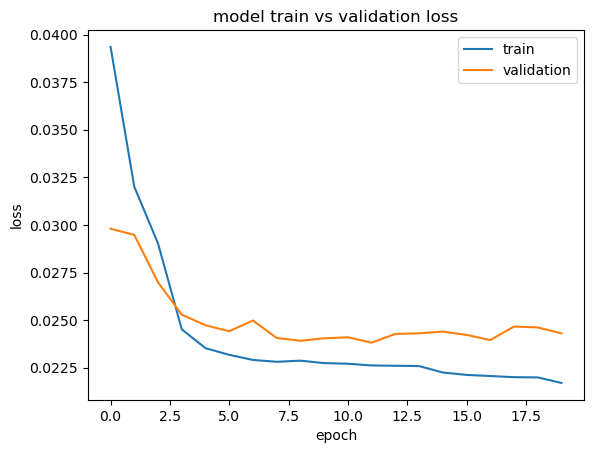

In [123]:
mae_emb_test = round(np.mean(model_supply.evaluate(X_test_scaled, y_test, verbose=-1)), 4)
baseline_mae = round(compute_baseline_mae(y_test, shift_days=1), 4)
baseline_p_mae = round(((mae_emb_test - baseline_mae) / baseline_mae) * 100, 2)
print(f"MAE Test: {mae_emb_test} (Baseline: {str(baseline_mae)} --- {baseline_p_mae}%)")

# Plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()